In [1]:
import os
import pandas as pd
import numpy as np


from sklearn import preprocessing
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

hyperparameters

In [2]:
random_seed = 42
cv=5
score = 'f1_weighted'

#### somte sampling

In [3]:
def Smoter(X, y, is_random=False):
    if is_random == True:
        random_lst = list(np.random.randint(0, 1000, 4))
    elif is_random == False:
        random_lst = [0] * 4

    print("rs:", random_lst)
    sm = SMOTE(random_state=random_lst[2], kind = 0.24)
    X_smote, y_smote = sm.fit_sample(X, y)

    return X_smote, y_smote

# load data_four_features

In [4]:
path = os.getcwd()+'/../data/20122018freshwater_four_feature.csv'
data_four_features = pd.read_csv(path, na_values = np.nan)

print(data_four_features.dtypes)
print(data_four_features.shape)

pH             float64
DO(mg/l)       float64
CODMn(mg/l)    float64
NH3-N(mg/l)    float64
本周水质             int64
dtype: object
(33612, 5)


In [5]:
X = data_four_features.drop(['本周水质'], axis=1) # Series
y = data_four_features['本周水质']-1 # Series

In [6]:
print("水质分布情况:")
print(y.value_counts())
print("\n各特征类型分布情况:")
print(data_four_features.dtypes.value_counts())

水质分布情况:
2    13272
3     8797
4     5472
1     2438
6     2146
5     1487
Name: 本周水质, dtype: int64

各特征类型分布情况:
float64    4
int64      1
dtype: int64


In [7]:
data_four_features.head()

,pH,DO(mg/l),CODMn(mg/l),NH3-N(mg/l),本周水质
0,7.09,10.0,5.7,0.33,3
1,6.94,12.0,5.4,0.40,3
2,7.20,9.6,4.9,0.34,3
3,6.80,11.6,6.3,0.59,4
4,6.75,11.0,6.2,0.64,4


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                       stratify = y, random_state = random_seed)
print("80%% train: %d/%d, 20%% test: %d/%d" %(X_train.shape[0], X.shape[0], X_test.shape[0], X.shape[0]))

80% train: 26889/33612, 20% test: 6723/33612


### normalize  train data

fulfill the Na with median, then standardized the data, output type ndarray

In [9]:
clean_pipeline = Pipeline([('imputer', preprocessing.Imputer(missing_values='NaN',strategy="median")),
                           ('std_scaler', preprocessing.StandardScaler()),])
X_train = clean_pipeline.fit_transform(X_train)
X_test = clean_pipeline.fit_transform(X_test)

# model selection

CE without cross validation

In [10]:
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train, y_train, test_size=0.25, 
                                       stratify = y_train, random_state = random_seed)

In [11]:
models = [
    LogisticRegression(),
    LinearDiscriminantAnalysis(),
    SVC(probability=True),
    DecisionTreeClassifier(),
    ExtraTreeClassifier(),
    GaussianNB(),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=random_seed),
    ExtraTreesClassifier(random_state=random_seed)
]

y_pred_proba_all = []

# 训练固定的基学习器
for model in models:
    model_name = model.__class__.__name__
    model.fit(X_train2, y_train2)
    y_pred_proba = model.predict_proba(X_valid)
    y_pred = model.predict(X_valid)
    print("model_name: %s, valid weighted f1 score:%f" %(model_name, f1_score(y_valid, y_pred, average="weighted")))
    y_pred_proba_all.append(y_pred_proba)

/Users/alex/anaconda3/envs/gc/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


model_name: LogisticRegression, valid weighted f1 score:0.618051
model_name: LinearDiscriminantAnalysis, valid weighted f1 score:0.569881
model_name: SVC, valid weighted f1 score:0.886775
model_name: DecisionTreeClassifier, valid weighted f1 score:0.987807
model_name: ExtraTreeClassifier, valid weighted f1 score:0.888785
model_name: GaussianNB, valid weighted f1 score:0.812976
model_name: KNeighborsClassifier, valid weighted f1 score:0.891579
model_name: RandomForestClassifier, valid weighted f1 score:0.994051
model_name: ExtraTreesClassifier, valid weighted f1 score:0.973277


In [34]:
classifier_num = 9
population_num = 1000
retain_population_num = 100
max_iteration = 100
population_weights = np.zeros((population_num, classifier_num))
population_retain_weights = np.zeros((retain_population_num, classifier_num))
population_score = []
population_retain_score = []
all_best_weights = np.zeros((max_iteration, classifier_num)) # 所有迭代中最好的种群
all_best_f1s = np.zeros(max_iteration) # 所有迭代中最好的f1

mu = np.zeros(classifier_num)
sigma = np.ones(classifier_num)


In [40]:
# 在训练集上: 训练每个基学习器的投票参数
for i in range(max_iteration):
    print("Iteration: %d" %(i))
    # 该次迭代的所有种群们
    population_score = np.zeros(population_num)
    population_weights = np.zeros((population_num, classifier_num))
    # 该次迭代的优势种群们
    population_retain_score = np.zeros(retain_population_num)
    population_retain_weights = np.zeros((retain_population_num, classifier_num))
    
    # 生成所有种群
    for j in range(classifier_num):
        w = np.random.normal(mu[j], sigma[j]+700/(i+1), population_num)
        population_weights[:,j] = w
        
    # 映射所有种群的权重至[0:1]    
    for j in range(population_num):
        w2 = np.zeros(classifier_num)
        for k in range(classifier_num):
            w2[k] = np.exp(-population_weights[j][k]*population_weights[j][k])
            # w2[k] = np.exp(population_weights[j][k])/np.sum(np.exp(population_weights[j]))
        population_weights[j] = w2
    
    # 计算所有种群得分
    for j in range(population_num):
        y_pred_ensemble_proba = np.zeros((len(y_valid), 6)) # 集成器概率向量
        # 为每一个基学习器乘上权重
        for k in range(classifier_num):
            y_pred_ensemble_proba += y_pred_proba_all[k] * population_weights[j][k]
        y_pred_ensemble = np.argmax(y_pred_ensemble_proba, axis=1)
        f1 = f1_score(y_valid, y_pred_ensemble, average="weighted")
        population_score[j] = f1

    # 所有种群得分按降序排列
    retain_index = np.argsort(-np.array(population_score))[:retain_population_num]
    
    # 记录该次迭代中的优势种群们
    population_retain_weights = population_weights[retain_index]
    population_retain_score = np.array(population_score)[retain_index]
    
    # 记录每次迭代最好的种群和value
    all_best_weights[i] = population_retain_weights[0]
    all_best_f1s[i] = population_retain_score[0]
    
    # 更新mu，sigma为优势种群们的分布
    mu = np.mean(population_retain_weights, axis = 0)
    sigma = np.std(population_retain_weights, axis = 0) #default: ddof = 0, The divisor used in calculations is N - ddof
#     print("mu\n",mu)
#     print("sigma\n", sigma)
#     print("Weighted F1 Score after rank")
#     print(population_retain_score)
#     print("Weights")
#     print(population_retain_weights)

Iteration: 0


/Users/alex/anaconda3/envs/gc/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

In [41]:
last_weight = population_retain_weights[0]
last_f1 = all_best_f1s[-1]
best_f1 = all_best_f1s[np.argmax(all_best_f1s)]
best_weight = population_retain_weights[np.argmax(all_best_f1s)]
print("Last f1: %f" % (last_f1))
print("Best f1: %f" % (best_f1))
print("Last Weight: %s" %(last_weight))
print("Best Weight: %s" %(best_weight))
print("Last mu\n",mu)
print("Last sigma\n", sigma)

Last f1: 0.994051
Best f1: 0.994052
Last Weight: [6.92235471e-045 1.20492856e-037 5.96628338e-024 7.86603983e-011
 1.00574821e-013 1.24564609e-001 2.47115594e-071 8.24179046e-001
 8.64699903e-117]
Best Weight: [1.12660992e-030 7.07461096e-001 3.30854254e-002 1.01045657e-001
 2.26331620e-176 1.89247094e-004 2.77796553e-023 9.73206777e-001
 4.31925945e-036]
Last mu
 [0.05587584 0.03650158 0.00799126 0.02885989 0.00531625 0.01426472
 0.00908654 0.53010577 0.07294999]
Last sigma
 [0.18265499 0.11693676 0.0412887  0.0914033  0.0219421  0.06693403
 0.03857639 0.33923456 0.23235347]


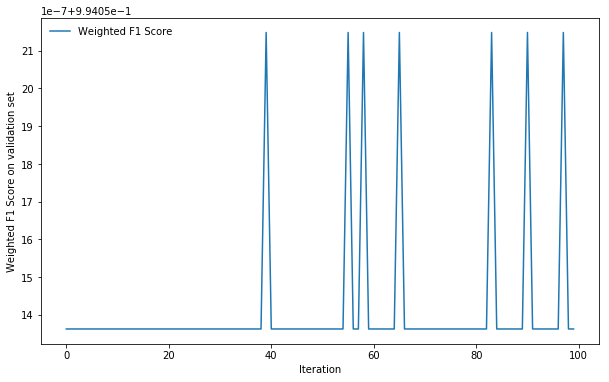

In [42]:
plt.figure(figsize=(10,6))
plt.plot(all_best_f1s, label = 'Weighted F1 Score')
plt.xlabel('Iteration')
plt.ylabel('Weighted F1 Score on validation set')
plt.legend(frameon=False)

In [45]:
plt.savefig('../img/weighed_F1_iteration(1-9).eps',format='eps')

<Figure size 432x288 with 0 Axes>

测试集

In [44]:
y_test_pred_proba_all = []
for model in models:
    model_name = model.__class__.__name__
    y_test_pred_proba = model.predict_proba(X_test)
    y_test_pred = model.predict(X_test)
    print("model_name: %s, test accuracy:%f, weighted f1 score:%f" %(model_name, accuracy_score(y_test, y_test_pred), f1_score(y_test, y_test_pred, average="weighted")))
    y_test_pred_proba_all.append(y_test_pred_proba)
    
    
y_test_pred_ensemble_proba = np.zeros((len(y_test), 6)) # 集成器概率向量

# 为每一个基学习器乘上权重
for k in range(classifier_num):
    y_test_pred_ensemble_proba += y_test_pred_proba_all[k] * best_weight[k]
y_test_pred_ensemble = np.argmax(y_test_pred_ensemble_proba, axis=1) + 1

print(classification_report(y_test, y_test_pred_ensemble))

cm = confusion_matrix(y_test, y_test_pred_ensemble)
i=0
acc_all = np.zeros(6)
for c in cm:
    acc_all[i] = c[i]/np.sum(c)
    print("%d accuaracy: %f" %(i+1, acc_all[i]))
    i=i+1
print("acc:", np.sum(y_test == y_test_pred_ensemble)/y_test_pred_ensemble.shape[0])
print('f1_weighted', f1_score(y_test, y_test_pred_ensemble, average='weighted'))

model_name: LogisticRegression, test accuracy:0.670980, weighted f1 score:0.620574
model_name: LinearDiscriminantAnalysis, test accuracy:0.625019, weighted f1 score:0.576099


/Users/alex/anaconda3/envs/gc/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


model_name: SVC, test accuracy:0.895880, weighted f1 score:0.894545
model_name: DecisionTreeClassifier, test accuracy:0.970846, weighted f1 score:0.970989
model_name: ExtraTreeClassifier, test accuracy:0.880113, weighted f1 score:0.880194
model_name: GaussianNB, test accuracy:0.824037, weighted f1 score:0.822296
model_name: KNeighborsClassifier, test accuracy:0.897813, weighted f1 score:0.897799
model_name: RandomForestClassifier, test accuracy:0.976052, weighted f1 score:0.976184
model_name: ExtraTreesClassifier, test accuracy:0.962517, weighted f1 score:0.962632
             precision    recall  f1-score   support

          1       0.91      0.99      0.95       488
          2       0.99      0.98      0.98      2655
          3       0.98      0.98      0.98      1760
          4       0.98      0.97      0.97      1094
          5       0.93      0.93      0.93       297
          6       0.96      0.99      0.97       429

avg / total       0.98      0.98      0.98      6723

1 

In [48]:
np.save("../npy/CE_best_weights(1-9).npy", best_weight)
np.save("../npy/CE_best_mu(1-9).npy", mu)
np.save("../npy/CE_best_sigma(1-9).npy", sigma)
import pickle
for model in models:
    model_name = model.__class__.__name__
    with open("../pkl/CE_" + model_name + ".pkl", "wb") as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

In [19]:
# model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
#        max_depth=20, min_child_weight=1, missing=None, n_estimators=1000,
#        n_jobs=-1, nthread=None, objective='binary:logistic', random_state=0,
#        reg_alpha=0, reg_lambda=1, scale_pos_weight=10, seed=42, silent=True,
#        subsample=0.8)

# model.fit(X_train, y_train)
# y_test_pred = model.predict(X_test)
# print(f1_score(y_test, y_test_pred, average="weighted"))

In [20]:
# param_test1 = {
#     'n_estimators':np.arange(10,100,20),
# }

# gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
#                                                   gamma=0, 
#                                                   subsample=0.8, 
#                                                   colsample_bytree=0.8,
#                                                   max_depth=4,
#                                                   objective= 'binary:logistic', 
#                                                   scale_pos_weight=1, 
#                                                   seed=random_seed), 
#                                                  param_grid = param_test1, scoring=score, n_jobs=-1, cv=cv)
# gsearch1.fit(X_train, y_train)

# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [21]:
# best_clf = gsearch1.best_estimator_
# best_clf.fit(X_train, y_train)

# y_test_pred = best_clf.predict(X_test)

# print("Test f1: %f" %(f1_score(y_test, y_test_pred, average="weighted")))